# Quadratization tutorial

In [1]:
import sympy as sp  # version 11.1.1
import qbee  # version 0.8.0
from qbee import *

/mnt/c/Users/а/IdeaProjects/QBee/qbee/util.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


This tutorial presents an implementation of *quadratization*, as introduced in [this article](https://link.springer.com/chapter/10.1007/978-3-030-79987-8_9)([arxiv](https://arxiv.org/abs/2103.08013)).

Consider a system of ODEs
$$
x_1' = f_1(\bar x),\ \dots,\ x_n' = f_n(\bar x),
$$
where $\bar x = (x_1, \dots, x_n)$ and $f_1,\dots, f_n \in \mathbb{C}[\bar x]$ (are polynomials in $\bar x$).

Then a list of new variables
$$
w_1 = g_1(\bar w),\ \dots,\ g_m(\bar w)
$$
is said to a *quadratization* if there exist polynomials $h_1, \dots, h_{n+m} \in \mathbb{c}[\bar x, \bar w]$ of degree at most two (quadratic) such that
$$
\begin{array}{ll}
x_i' = h_i(\bar x, \bar w) & \text{for every } 1 \le i \le n \\
w_j' = h_{j+n}(\bar x, \bar w) & \text{for every } 1 \le j \le m
\end{array}
$$

We will illustrate it on a simple example. Consider a system:
$$
\begin{cases}
x' = y^3 \\
y' = x^3
\end{cases}
$$
Then $\bar x = (x, y)$ and $\bar f = (y^3, x^3)$

In-code representation of the system will be:

In [2]:
x, y = functions("x, y")
system = [
    (x, y**3),
    (y, x**3)
]

Let's find a quadratization now!

In [3]:
res = quadratize(system)
res.print()

Nodes processed: 0 nodes [00:00, ? nodes/s]

Nodes processed: 0 nodes [00:00, ? nodes/s]

w0 = y**2
w1 = x**2
w2 = x*y

x' = w0*y
y' = w1*x
w0' = 2*w1*w2
w1' = 2*w0*w2
w2' = w0**2 + w1**2


Firstly, we print out a quadratization itself: $\bar g = (y^2, x^2, xy)$. And then, we display a quadratized system. Let's break down how these equations were produced.
For instance, pick $w_2 = xy$. Then
$$
w_2' = (xy)' = x'y + xy' = y^4 + x^4 = w_0^2 + w_1^2
$$

 Notice that each polynomial in $\bar g = (y^2, x^2, xy)$ is actually a monomial. Such quadratizations are called *monomial* quadratizations. Quadratizations can also be non-monomial (check [this article](https://arxiv.org/abs/2011.03959)), but effective algorithm of finding such is unknown to us. Nevertheless, it is the monomial quadratizations that are the target of the search for some applications (see [example from chemistry](https://arxiv.org/abs/2007.08910)).

Also notice that the found quadratization is the smallest size possible (try finding a smaller one yourself!). Such quadratization are called *optimal* quadratizations. QBee will always find optimal quadratizations under the given conditions.

Now, let's check if the quadratized systems is actually the same as the original one not only symbolically but numerically too.

In [4]:
import numpy as np
from qbee.experimental import to_odeint  # converts a system to scipy.integrate.odeint with already filled `y0`

x0 = {"x": 0.1, "y": -0.1}
original_odeint = to_odeint(system, x0)
quadratized_odeint = to_odeint(res, x0)

timespan = np.linspace(0, 100, 1000)
original_sol = original_odeint(timespan)
quadratized_sol = quadratized_odeint(timespan)

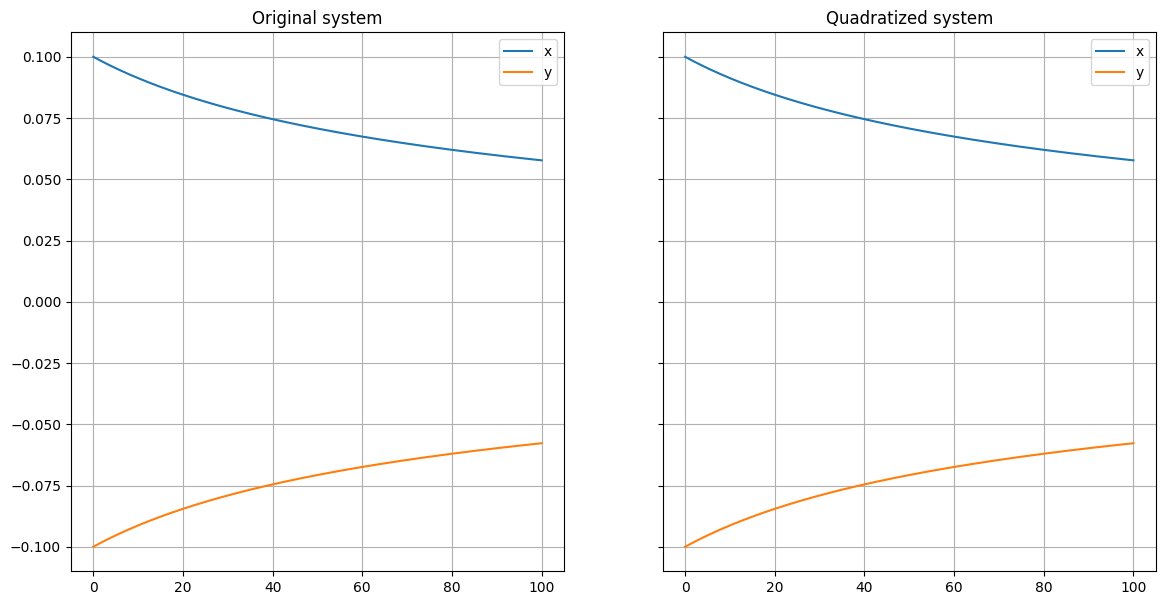

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 7))

ax1.set_title("Original system")
ax1.plot(timespan, original_sol[:, 0], label="x")
ax1.plot(timespan, original_sol[:, 1], label="y")
ax1.legend()
ax1.grid()

ax2.set_title("Quadratized system")
ax2.plot(timespan, quadratized_sol[:, 0], label="x")
ax2.plot(timespan, quadratized_sol[:, 1], label="y")

ax2.legend()
ax2.grid()

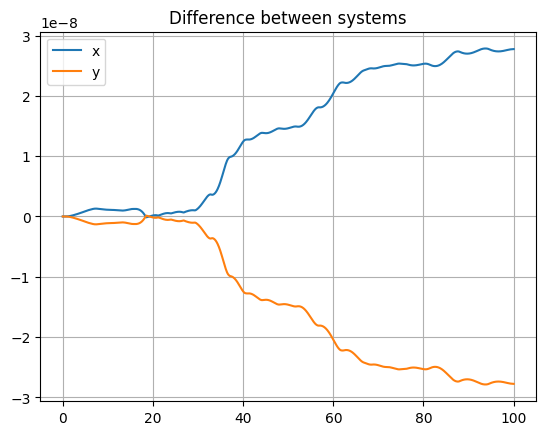

In [6]:
plt.title("Difference between systems")
plt.plot(timespan, original_sol[:, 0] - quadratized_sol[:, 0], label="x")
plt.plot(timespan, original_sol[:, 1] - quadratized_sol[:, 1], label="y")
plt.legend()
plt.grid()

# Note scale 1e-8

## Polynomialization


However, what if input ODE systems are not polynomial? In such case a similar technique called *polynomialization* can help.
Let's observe it in action!

In [7]:
x, y = functions("x, y")

system = [
    (x, sp.sin(x**2) + y),
    (y, sp.cos(x**2) + x)
]

# Currently, there is no rule to estimate an upper bound for a polynomialization in general,
# so you may have to pick it yourself, if the default value is too small;
res = polynomialize(system, upper_bound=5)
res.print_substitutions()
print()
res.print()

Nodes processed: 0 nodes [00:00, ? nodes/s]

w_0 = cos(x**2)
w_1 = sin(x**2)

x' = w_1 + y
y' = w_0 + x
w_0' = -2*w_1*x*(w_1 + y)
w_1' = 2*w_0*x*(w_1 + y)


In QBee polynomialization is only *suboptimal*, which means that we process only a subset of all possible variables. It is especially actual when expressions with real powers such as $x^{1.6}$ are processed.

## Parameters and inputs

In practice system of ODEs consist not only state variables $\bar x$, but *parameters* and *inputs*.
* Parameters are numerical values unknown to us
* Inputs are unknown functions of the independent variable ($t$) of the system. Their derivatives may or may not be present in the system.

Let's see how it works in the

In [11]:
x, y, u = functions("x, y, u")  # `u` is an inputs since it does not present in the left-hand side of the system
a, b = parameters("a, b")

system = [
    (x, a*y**2 * u),
    (y, b*(y ** -2) - 1)
]

res = quadratize(system)
res.print()

Nodes processed: 0 nodes [00:00, ? nodes/s]

Nodes processed: 0 nodes [00:00, ? nodes/s]

w0 = 1/y
w1 = y**(-3)
w2 = y**2

x' = a*u*w2
y' = b*w0**2 - 1
w0' = -b*w0*w1 + w0**2
w1' = -3*b*w1**2 + 3*w0*w1
w2' = 2*b*w1*w2 - 2*w0*w2


We can also put parameters and inputs to numerical integrator:

In [31]:
import numpy as np
from qbee.experimental import to_odeint


x0 = {"x": 0.1, "y": 1.01}
p0 = {"a": 2, "b": 0.1}

t = qbee.INDEPENDENT_VARIABLE
inp0 = {"u": sp.sin(t)}

original_odeint = to_odeint(system, x0, p0, inp0)
quadratized_odeint = to_odeint(res, x0, p0, inp0)

timespan = np.linspace(0, 50, 1000)
original_sol = original_odeint(timespan)
quadratized_sol = quadratized_odeint(timespan)

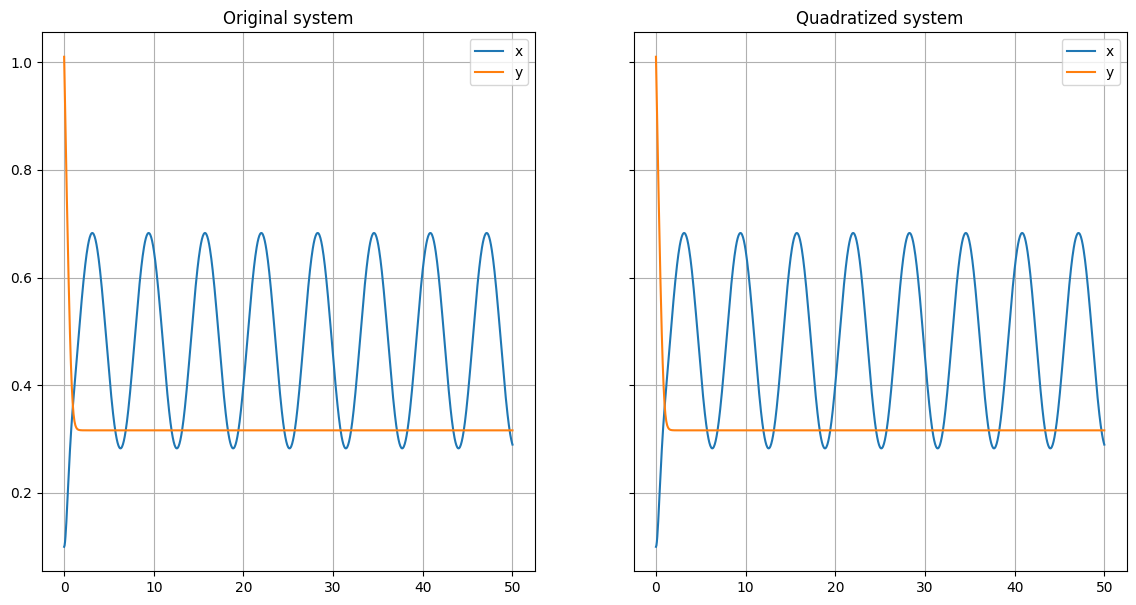

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 7))

ax1.set_title("Original system")
ax1.plot(timespan, original_sol[:, 0], label="x")
ax1.plot(timespan, original_sol[:, 1], label="y")
ax1.legend()
ax1.grid()

ax2.set_title("Quadratized system")
ax2.plot(timespan, quadratized_sol[:, 0], label="x")
ax2.plot(timespan, quadratized_sol[:, 1], label="y")

ax2.legend()
ax2.grid()

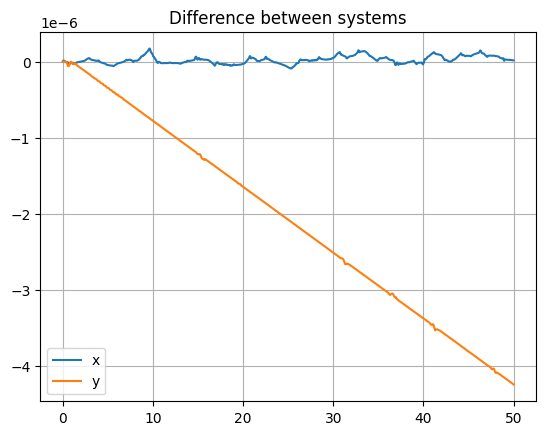

In [33]:
plt.title("Difference between systems")
plt.plot(timespan, original_sol[:, 0] - quadratized_sol[:, 0], label="x")
plt.plot(timespan, original_sol[:, 1] - quadratized_sol[:, 1], label="y")
plt.legend()
plt.grid()

### Putting it all together: Species’ reaction model for combustion.

$$
\begin{equation}
\begin{split}
  \dot x_1 &= -A \exp{\Big(-\frac{E}{R u(t)}\Big)} x_1^{0.2} x_2^{1.3}\\
  \dot x_2 &= 2 \dot x_1\\
  \dot x_3 &= -\dot x_1 \\
  \dot x_4 &= -2 \dot x_1,
\end{split}
\end{equation}
$$

In [36]:
x1, x2, x3, x4, u = functions("x_1, x_2, x_3, x_4, u")
A, E, R = parameters("A, E, R")
eq1 = -A * sp.exp(-E / (R * u)) * x1 ** 0.2 * x2 ** 1.3

system = [
    (x1, eq1),
    (x2, 2 * eq1),
    (x3, -eq1),
    (x4, -2 * eq1)
]

# {T: 2} means than T can have a derivative of order at most two => T''
res = polynomialize_and_quadratize(system, input_der_orders={u: 2})
res.print()

Nodes processed: 0 nodes [00:00, ? nodes/s]

Nodes processed: 0 nodes [00:00, ? nodes/s]

w_0 = exp(-E/(R*u))
w_1 = x_1**0.2
w_2 = x_2**1.3
w_3 = w_0*w_1
w_4 = u'/u**2
w_5 = u**(-2)
w_6 = u'/u
w_7 = 1/u
w_8 = w_0*w_1*w_2/x_1
w_9 = w_0*w_1*w_2/x_2

x_1' = -A*w_2*w_3
x_2' = -2*A*w_2*w_3
x_3' = A*w_2*w_3
x_4' = 2*A*w_2*w_3
w_0' = E*w_0*w_4/R
w_1' = -A*w_1*w_8/5
w_2' = -13*A*w_2*w_9/5
w_3' = -A*w_3*w_8/5 + E*w_3*w_4/R
w_4' = u''*w_5 - 2*w_4*w_6
w_5' = -2*w_5*w_6
w_6' = u''*w_7 - w_6**2
w_7' = -w_6*w_7
w_8' = 4*A*w_8**2/5 - 13*A*w_8*w_9/5 + E*w_4*w_8/R
w_9' = -A*w_8*w_9/5 - 3*A*w_9**2/5 + E*w_4*w_9/R


In [40]:
import numpy as np
from qbee.experimental import to_odeint

x0 = {"x_1": 1.0, "x_2": 2.0, "x_3": 0.5, "x_4": 1.0}
p0 = {"A": 2, "E": 1.5, "R": 1}

t = qbee.INDEPENDENT_VARIABLE
inp0 = {"u": t}

original_odeint = to_odeint(system, x0, p0, inp0)
quadratized_odeint = to_odeint(res, x0, p0, inp0)

timespan = np.linspace(0, 10, 1000)
original_sol = original_odeint(timespan)
quadratized_sol = quadratized_odeint(timespan)

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1001001001001D-01   r2 =                  NaN


/home/aratorn/.local/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


TypeError: Cannot convert expression to float